In [13]:
%load_ext autoreload
%autoreload 2
%cd '/home/xingyu/Projects/PlasticineLab'
%pwd

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import numpy as np
from imitation.agent import Agent, sample_traj
from plb.envs import make
from imitation.train import get_args
from plb.engine.taichi_env import TaichiEnv
from plb.optimizer.solver import Solver
from plb.algorithms.logger import Logger

device = 'cuda'

log_dir = './data/connect'
args = get_args("")

obs_channel = len(args.img_mode)
img_obs_shape = (args.image_dim, args.image_dim, obs_channel)

env = make(args.env_name, nn=(args.algo == 'nn'), sdf_loss=args.sdf_loss,
           density_loss=args.density_loss, contact_loss=args.contact_loss,
           soft_contact_loss=args.soft_contact_loss, chamfer_loss=args.chamfer_loss)
env.seed(args.seed)
taichi_env: TaichiEnv = env.unwrapped.taichi_env
T = env._max_episode_steps
action_dim = taichi_env.primitives.action_dim

plb_logger = Logger(log_dir)
solver = Solver(taichi_env, plb_logger, None,
                n_iters=(args.gd_num_steps + T - 1) // T, softness=args.softness, horizon=T,
                **{"optim.lr": args.lr, "optim.type": args.optim, "init_range": 0.0001})
agent = Agent(args, solver, img_obs_shape, action_dim, num_tools=2, device=device)

from imitation.utils import load_target_info

target_info = load_target_info(args, device)
np_target_imgs, target_imgs, np_target_mass_grids = target_info['np_target_imgs'], target_info['target_imgs'], target_info['np_target_mass_grids']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/xingyu/Projects/PlasticineLab
Building primitive
action:
  dim: 6
  scale: (0.7, 0.005, 0.005, 0.005, 0.0, 0.0)
color: (0.8, 0.8, 0.8)
friction: 0.9
h: 0.3
init_pos: (0.55, 0.2, 0.5)
init_rot: (0.707, 0.707, 0.0, 0.0)
lower_bound: (0.0, 0.09, 0.0)
r: 0.03
shape: RollingPinExt
upper_bound: (1.0, 1.0, 1.0)
variations: None
Building primitive
action:
  dim: 6
  scale: (0.015, 0.0, 0.0, 0.0, 0.0, 0.0)
color: (0.8, 0.8, 0.8)
friction: 0.9
init_pos: (0.7, 0.1, 0.5)
init_rot: (0.707, 0.707, 0.0, 0.0)
lower_bound: (0.0, 0.0, 0.0)
shape: Box
size: (0.015, 0.15, 0.1)
upper_bound: (1.0, 1.0, 1.0)
variations: None
{'init_pos': (0.5, 0.03576, 0.5), 'width': (0.2, 0.03575, 0.2), 'color': 100}
Initialize Renderer
bake_size: 6  
camera_pos: (0.5, 0.4, 1.9)  
camera_rot: (0.2, 0.0)  
dx: 0.006666666666666667  
image_res: (64, 64)  
light_direction: (0.0, 1.0, 1.0)  
max_num_particles: 1000000  
max_ray_depth: 

In [ ]:
# Temp test

# render_kwargs = {'mode': 'rgb', 'target': False}
# obs = taichi_env.render(**render_kwargs)
# obs2 = taichi_env.render(**render_kwargs)
# import matplotlib.pyplot as plt
# error = np.abs(obs[:, :, 3] -obs2[:, :, 3])
# print(np.max(error))
# print(np.min(obs[:, :, 3]), np.max(obs[:, :, 3]))
# plt.imshow(error[:, :])
# plt.colorbar()

In [14]:
import torch
import matplotlib.pyplot as plt
from imitation.utils import img_to_np, write_number, img_to_tensor
from plb.utils.visualization_utils import make_grid, save_rgb
import os.path as osp
import sys
import json

sys.path.insert(0, '/home/xingyu/Projects/PlasticineLab/')

# Trained on hindsight goals
# agent_path = 'data/local/0629_PushSpread_train_fea/0629_PushSpread_train_fea_2021_07_01_11_34_12_0001/agent_350.ckpt'
# Trained on real goals
# agent_path = 'data/autobot/0805_PushSpread_fea/0805_PushSpread_fea/0805_PushSpread_fea_2021_08_05_16_50_05_0002/agent_50.ckpt'
# agent_path = 'data/autobot/0805_PushSpread_fea/0805_PushSpread_fea/0805_PushSpread_fea_2021_08_05_16_50_05_0002/agent_50.ckpt'
agent_path = 'data/autobot/0807_PushSpread_fea/0807_PushSpread_fea/0807_PushSpread_fea_2021_08_07_17_20_51_0001/agent_30.ckpt'
vv_path = osp.join(osp.dirname(agent_path), 'variant.json')
with open(vv_path, 'rb') as f:
    agent_vv = json.load(f)
args.__dict__.update(**agent_vv)
print('bin succ:', args.bin_succ)
agent = Agent(args, solver, img_obs_shape, action_dim, num_tools=2, device=device)
agent.feas.eval()
agent.load(agent_path)
taichi_env.loss.set_target_update(False)

# actor_agent_path = 'data/autobot/0802_PushSpread_train_policy/0802_PushSpread_train_policy/0802_PushSpread_train_policy_2021_08_02_15_28_30_0001/agent_1800.ckpt'
# agent.load_actor(actor_agent_path)
# agent_dataset = './data/autobot/0718_PushSpread_train_fea/0718_PushSpread_train_fea/0718_PushSpread_train_fea_2021_07_20_11_34_11_0001/agent_dataset.gz'
from imitation.buffer import ReplayBuffer

buffer = ReplayBuffer()
# buffer.load(agent_dataset)

bin succ: False
class Agent: obs_shape:  (64, 64, 8)
Agent loaded from data/autobot/0807_PushSpread_fea/0807_PushSpread_fea/0807_PushSpread_fea_2021_08_07_17_20_51_0001/agent_30.ckpt


In [ ]:
# traj_id = 77
# horizon = 50
# action_mask = buffer.buffer['action_mask'][traj_id * horizon]
# print('action mask:', action_mask)
# print(buffer.get_tid(action_mask))
# idx = traj_id * horizon
# optimal_step = buffer.get_optimal_step().flatten()
# max_step = optimal_step[idx]
# print('optimal:', buffer.buffer['target_ious'][traj_id * horizon + max_step])
#
# init_v, target_v = buffer.buffer['init_v'][idx][0], buffer.buffer['target_v'][idx][0]
# print('init_v: {}, target_v: {}'.format(init_v, target_v))
# ious = buffer.buffer['target_ious'][idx:idx + horizon]
# # print('max:', np.argmax(buffer.buffer['target_ious'][:buffer.cur_size]))
# action_mask = buffer.buffer['action_mask'][idx]
# obs = buffer.buffer['obses'][idx]
# tensor_obs = img_to_tensor(np.array(obs[None]), args.img_mode).to(device)
# tid = buffer.get_tid(action_mask)
# print(tensor_obs.shape, target_imgs[target_v].shape)
# with torch.no_grad():
#     pred_iou = agent.fea_pred(tensor_obs, target_imgs[target_v][None], tid)[0].item()
#
# print('gt_ious:', ious)
# print('pred_iou:', pred_iou)

In [ ]:
# imgs = []
# feas = []
# from imitation.test_trajectories import test_init_v, test_target_v
#
# test_init_v = np.array([95, 95, 95, 91, 91, 91, 80])
# test_target_v = np.array([25, 195, 128, 21, 191, 128, 20])
#
# ## Training set
# # test_init_v = np.array([80, 90, 70, 85, 81, 95, 65])
# # test_target_v = np.array([20, 30, 10, 25, 21, 25, 25])
#
# for tid in [0, 1]:  # TODO Reverse the order for now . Remove this after using 0722 agent dataset
#     for (init_v, target_v) in zip(test_init_v, test_target_v):
#         env.reset(init_v=init_v, target_v=target_v)
#
#         render_kwargs = {'mode': 'rgb', 'target': False}
#         obs = taichi_env.render(**render_kwargs)
#         tensor_obs = img_to_tensor(np.array(obs[None]), args.img_mode).to(device)
#         with torch.no_grad():
#             iou = agent.fea_pred(tensor_obs, target_imgs[target_v][None], tid)[0].item()
#         img = obs * 0.7 + np_target_imgs[target_v] * 0.3
#         imgs.append(img)
#         feas.append(iou)
#
# for img, fea in zip(imgs, feas):
#     write_number(img, fea)
# grid_img = make_grid(np.array(imgs), ncol=len(imgs) // 2, padding=3, pad_value=0.5)
# save_rgb(osp.join(log_dir, 'one_step.png'), grid_img)

In [15]:
import json
from imitation.encoder.vae import VAE

vae_dir = 'data/autobot/0729_vae/0729_vae/0729_vae_2021_07_29_20_03_08_0006/'
vae_path = osp.join(vae_dir, 'encoder_95.pth')
vae_vv_path = osp.join(vae_dir, 'variant.json')
with open(vae_vv_path, 'r') as f:
    vae_vv = json.load(f)
vae = VAE(4)
vae.load_state_dict(torch.load(vae_path))
vae = vae.cuda()

In [19]:
import os

execute = True
from imitation.compose_skills import plan, visualize_all_traj
from imitation.compose_skills import execute
from imitation.compose_skills import visualize_adam_info, visualize_mgoal

opt_mode = 'adam'  # ['search', 'sample', 'adam']
save_path = f'./data/connect/{opt_mode}'
if not os.path.exists(save_path):
    os.mkdir(save_path)

test_init_v = np.array([95, 95, 95, 91, 91, 91, 80])
test_target_v = np.array([25, 195, 128, 21, 191, 128, 20])

opt_args = {}
if opt_mode == 'search':
    opt_args['mid_goals'] = np_target_imgs[test_target_v]
elif opt_mode == 'sample':
    opt_args['num_sample'] = 10000
    opt_args['vae'] = vae
elif opt_mode == 'adam':
    opt_args['adam_sample'] = 400
    opt_args['adam_iter'] = 3000
    opt_args['adam_lr'] = 5e-2
    opt_args['min_zlogl'] = float(-30)
    opt_args['vae'] = vae
    opt_args['save_goal_his'] = False
for i, (init_v, target_v) in enumerate(zip(test_init_v, test_target_v)):
    if i not in [2]:
        continue
    plan_info = {'env': env, 'init_v': init_v, 'target_v': target_v}
    plan_info.update(**opt_args)
    plan_info.update(**target_info)
    best_traj, all_traj, traj_info = plan(agent, plan_info, opt_mode=opt_mode)
    img, sorted_idxes = visualize_all_traj(all_traj, overlay=False)
    save_grid_img = make_grid(img[:10], ncol=5, padding=5, pad_value=0.5)
    save_rgb(osp.join(save_path, f'plan_{i}.png'), save_grid_img[:, :, :3])

    execute_name = osp.join(save_path, f'execute_{i}.gif')
    execute(env, agent, best_traj, target_info, execute_name)

    if opt_mode == 'adam':
        visualize_adam_info(traj_info, savename=osp.join(save_path, f'adam_{i}.png'), topk=8)
        if 'goal_his' in traj_info:
            goal_his = np.concatenate(traj_info['goal_his'], axis=1)  # traj_info goal his: [4 (list), 200, 10, img_dims]
            goal_his = goal_his[:, sorted_idxes[:10]]
            visualize_mgoal(goal_his, savename=osp.join(save_path, f'adam_{i}.gif'))

{'init_pos': (0.5, 0.03576, 0.5), 'width': (0.2, 0.03575, 0.2), 'color': 100}
initialize: [0.5 0.4 1.9] [0.2 0. ]
iter: 0
iter: 100
iter: 200
iter: 300
iter: 400
iter: 500
iter: 600
iter: 700
iter: 800
iter: 900
iter: 1000
iter: 1100
iter: 1200
iter: 1300
iter: 1400
iter: 1500
iter: 1600
iter: 1700
iter: 1800
iter: 1900
iter: 2000
iter: 2100
iter: 2200
iter: 2300
iter: 2400
iter: 2500
iter: 2600
iter: 2700
iter: 2800
iter: 2900
{'init_pos': (0.5, 0.03576, 0.5), 'width': (0.2, 0.03575, 0.2), 'color': 100}
initialize: [0.5 0.4 1.9] [0.2 0. ]
MoviePy - Building file ./data/connect/adam/execute_2.gif with imageio.


In [21]:
for j in range(5):
    execute_name = osp.join(save_path, f'execute_{i}_run_{j}.gif')
    execute(env, agent, all_traj[j], target_info, execute_name)

{'init_pos': (0.5, 0.03576, 0.5), 'width': (0.2, 0.03575, 0.2), 'color': 100}
initialize: [0.5 0.4 1.9] [0.2 0. ]
MoviePy - Building file ./data/connect/adam/execute_6_run_0.gif with imageio.


{'init_pos': (0.5, 0.03576, 0.5), 'width': (0.2, 0.03575, 0.2), 'color': 100}
initialize: [0.5 0.4 1.9] [0.2 0. ]
MoviePy - Building file ./data/connect/adam/execute_6_run_1.gif with imageio.


{'init_pos': (0.5, 0.03576, 0.5), 'width': (0.2, 0.03575, 0.2), 'color': 100}
initialize: [0.5 0.4 1.9] [0.2 0. ]
MoviePy - Building file ./data/connect/adam/execute_6_run_2.gif with imageio.


{'init_pos': (0.5, 0.03576, 0.5), 'width': (0.2, 0.03575, 0.2), 'color': 100}
initialize: [0.5 0.4 1.9] [0.2 0. ]
MoviePy - Building file ./data/connect/adam/execute_6_run_3.gif with imageio.


{'init_pos': (0.5, 0.03576, 0.5), 'width': (0.2, 0.03575, 0.2), 'color': 100}
initialize: [0.5 0.4 1.9] [0.2 0. ]
MoviePy - Building file ./data/connect/adam/execute_6_run_4.gif with imageio.


4


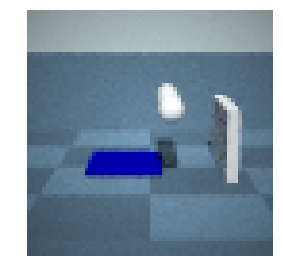

In [42]:
plt.figure()
b_imgs = best_traj['traj_img']
print(len(b_imgs))
plt.imshow(b_imgs[3][:,:, :3])
plt.axis("off")
plt.tight_layout()
plt.savefig('./test.png')


In [ ]:
from imitation.test_trajectories import test_agent

target_info = {'target_imgs': target_imgs,
               'np_target_imgs': np_target_imgs,
               'np_target_mass_grids': np_target_mass_grids}
trajs = test_agent(env, agent, test_init_v, test_target_v, target_info, save_path='./data/connect/rollout.gif')
print([traj['target_ious'][-1] for traj in trajs])